# Chapter 20 - Blankenbach - Case1a

This notebook implements the Blankenbacch Case1a isoviscous thermal convection benchmark.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

## Model setup

Boundary conditions are insulating on the sides, fixed temperature top and bottom.

Initial condition is:
$$
T(x,y) = T_{surf} + \frac{(T_{btm}-T_{surf})}{H} y + dT\cos(\frac{\pi x}{W}) \sin(\frac{\pi y}{H})
$$

Note that the origin of the coordinate system is in the upper right. $y$ increases downward, $x$ increases rightward.

In [2]:
function blankenbach_initial_conditions!(markers::Markers,Ttop,Tbtm,W,H)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        # T(x,y) = Tsurf + (Tbtm-Tsurf)/H * y + dT*cos(pi*x/W)
        markers.scalars[eta,i] = 1e23
        markers.scalars[T,i] = Ttop + (Tbtm-Ttop)/H*my + 10.0*cos(pi*mx/W)*sin(pi*my/H)
    end
end

function compute_nusselt(grid::CartesianGrid,T::Matrix{Float64},kThermal,Tbcval)
        dTdy = (T[2,:]-T[1,:])/(grid.yc[2]-grid.yc[1])
        kdTdy = kThermal*dTdy
        qcond = kThermal*(Tbcval[4]-Tbcval[3])/grid.H
        Nu = mean(kdTdy)/qcond;
    return Nu
end

function run_blankenbach_case1a(end_step=1;end_time=nothing)
    nx = 97
    ny = 97
    W = 1e6
    H = 1e6
    
    gx = 0.0
    gy = 10.0
    alpha = 2.5e-5; # thermal expansivity

    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    Tbcval = [0.,0.,273.,1273.]   
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 100e6*seconds_in_year # plot interval in seconds
    dtmax = plot_interval
    
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time blankenbach_initial_conditions!(markers,Tbcval[3],Tbcval[4],W,H)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 5.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);
    rho0 = 4000.0*ones(grid.ny,grid.nx);
    
    kappa = kThermal[1,1]/rho0[1,1]/Cp[1,1]
    diffusion_timescale = (grid.x[2]-grid.x[1])^2/kappa
    dtmax = minimum([dtmax,diffusion_timescale])
    
    local time = 0.0
    iout=0
    last_plot = 0.0

    local rho
    local rho_vx
    local rho_vy

    local eta_s
    local eta_n
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast
    
    nu_values=zeros(0)
    time_values=zeros(0)
    
    output_dir = "case1a"
    local terminate = false
    local itime=0
    while !terminate
        if itime >= end_step || (end_time != nothing && time >= end_time)
            terminate = true
        end
        
        rho_var = markers.scalarFields["rho"]
        T_var = markers.scalarFields["T"]
        for i in 1:markers.nmark
            markers.scalars[rho_var,i] = 4000.0*(1.0-alpha*(markers.scalars[T_var,i]-Tbcval[3]))
        end
        
        # Get density and viscosity from the markers.
        rho_new,eta_s_new = marker_to_basic_node(markers,grid,["rho","eta"]);        
        eta_n_new,Tlast_new = marker_to_stag(markers,grid,["eta","T"],"center")
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        
        if time > 0.0
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(rho,rho_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end

        Tlast = copy(Tlast_new)
        rho   = copy(rho_new)
        eta_s = copy(eta_s_new) 
        eta_n = copy(eta_n_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)

        # assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy,0.0) 
        solution = L\R
        vx,vy,P = unpack(solution,grid;ghost=true)
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        dt = compute_timestep(grid,vxc,vyc;cfl=0.25,dtmax=dtmax)
        
        Tlast = ghost_temperature_center(grid,Tlast,Tbcval);

        dTmax = Inf
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho0,Cp,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end
        # compute Nusselt number
        Nu = compute_nusselt(grid,Tnew,kThermal[1,1],Tbcval)
        
        # store Nusselt number for plotting
        append!(nu_values,Nu)
        append!(time_values,time)
        
        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval || terminate
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end

        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr Nu=",Nu," ",extrema(Tnew[2:end-1,2:end-1]))
    end
    return nu_values, time_values, markers, grid, dTemp, Tnew, Tlast
end

run_blankenbach_case1a (generic function with 2 methods)

Run the benchmark code for 10 timesteps and produce a ProfileSVG view:

In [11]:
using ProfileSVG
@time nu,t,markers,grid,dTemp,Tnew,Tlast = run_blankenbach_case1a(10,end_time=6e9*3.15e7)

Creating Markers...
  0.019499 seconds (19 allocations: 18.353 MiB, 76.70% gc time)
Initial condition...
  0.009272 seconds
Trying with timestep 1.0850694444444444e14
dTmax=0.8389001051637024 dt=3.444664902998236
Finished Step 1 time=3.444664902998236 Myr Nu=1.0525274659918917 (278.28903761343054, 1267.7030509918895)
Trying with timestep 1.0850694444444444e14
dTmax=0.6086707259528339 dt=3.444664902998236
Finished Step 2 time=6.889329805996472 Myr Nu=1.034396092189548 (278.20191513197796, 1267.7952655928489)
Trying with timestep 1.0850694444444444e14
dTmax=0.4875006690124337 dt=3.444664902998236
Finished Step 3 time=10.333994708994709 Myr Nu=1.024062184514347 (278.14864218934235, 1267.851926566973)
Trying with timestep 1.0850694444444444e14
dTmax=0.4249250194632168 dt=3.444664902998236
Finished Step 4 time=13.778659611992945 Myr Nu=1.0181608473606143 (278.11564233662665, 1267.8876117899297)
Trying with timestep 1.0850694444444444e14
dTmax=0.3880020989813602 dt=3.444664902998236
Finished

([1.0525274659918917, 1.034396092189548, 1.024062184514347, 1.0181608473606143, 1.014740045454917, 1.0127100148654058, 1.011467783405947, 1.010679621015175, 1.0101606341902842, 1.0098054476540428, 1.0095533141567503], [0.0, 1.0850694444444444e14, 2.1701388888888888e14, 3.255208333333333e14, 4.3402777777777775e14, 5.425347222222222e14, 6.510416666666666e14, 7.59548611111111e14, 8.680555555555555e14, 9.765625e14, 1.0850694444444445e15], Markers([1431.8191414238324 1882.218067333825 … 997171.2237485794 998707.5126263811; 319.69563197227654 1152.5106084888114 … 999074.3718203543 998452.0897107373], [1 1 … 96 96; 1 1 … 96 96], Dict{Any, Any}("T" => 1, "eta" => 3, "rho" => 2), [272.46794966634724 273.3516710882847 … 1272.9047363523844 1272.2423249352996; 4000.053095213738 3999.964695909498 … 3900.0096025011794 3900.075864415385; 1.0e23 1.0e23 … 1.0e23 1.0e23], Dict{Any, Any}("material" => 1), Int16[0 0 … 0 0], 331776), CartesianGrid([0.0, 10416.666666666666, 20833.333333333332, 31250.0, 4166

Run the benchmark code long enough to approach steady state.

In [ ]:
@time nu,t,markers,grid,dTemp,Tnew,Tlast = run_blankenbach_case1a(Inf,end_time=6e9*3.15e7);

Plot the time-evolution of the Nusselt number. Add a red dashed line that indicates the preferred benchmark value from Gerya.

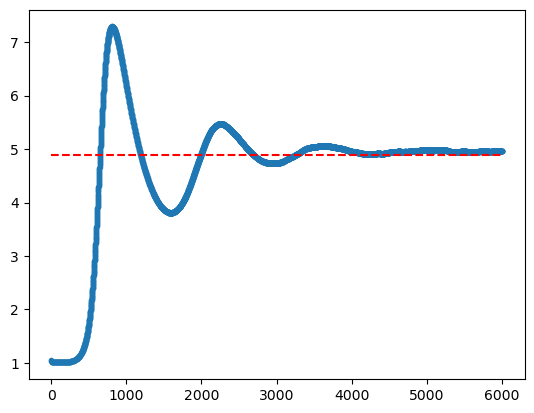

In [5]:
figure()
plot(t/3.15e7/1e6,nu,".")
plot([0.,6000.],[4.8844,4.8844],"r--")
show()

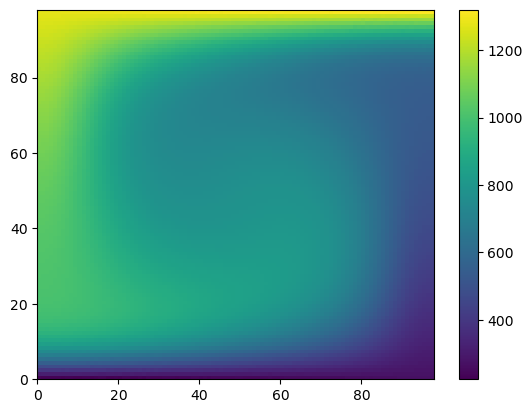

In [6]:
figure()
pcolor(Tlast)
colorbar()
show()
# print(size(Tnew))


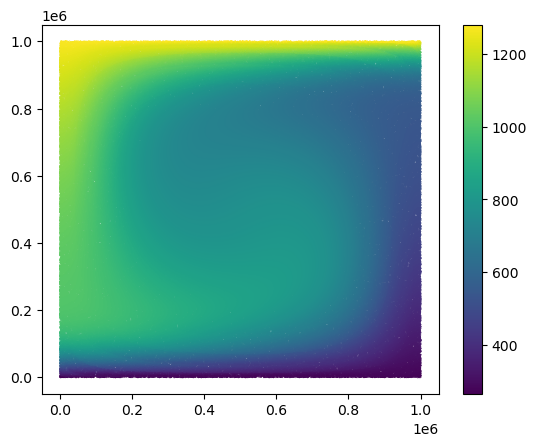

In [7]:
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T",],:],s=0.1)
colorbar()
show()

In [10]:
minimum(markers.scalars[markers.scalarFields["T"],:])

265.1161202128997